In [7]:
import yfinance as yf  # for data


import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
plt.rcParams['figure.figsize'] = [10, 6]
import warnings
warnings.filterwarnings('ignore')


### Getting data

Daiy data can be easily imported using `pandas_datareader`. For shorter intervals I will be using `yfinance`

In [8]:
# How yfinance can be used ""

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "SPY",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "7d",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1m",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2020-10-13 09:30:00-04:00,352.200012,352.209991,352.149994,352.170013,2280110
2020-10-13 09:31:00-04:00,352.200012,352.230011,351.864990,352.174988,305507
2020-10-13 09:32:00-04:00,352.160004,352.160004,351.850006,351.920013,260073
2020-10-13 09:33:00-04:00,351.899994,352.079987,351.790009,351.890015,265041
2020-10-13 09:34:00-04:00,351.880005,351.970001,351.609985,351.970001,234070
...,...,...,...,...,...
2020-10-21 15:55:00-04:00,343.369995,343.519989,343.299988,343.350006,428576
2020-10-21 15:56:00-04:00,343.350006,343.369995,343.190002,343.210114,481671
2020-10-21 15:57:00-04:00,343.214996,343.299988,343.049988,343.059998,441632


In [ ]:
data = yf.download(tickers = "SPY",period = "7d",interval = "1m",group_by = 'ticker',auto_adjust = True,prepost = False,threads = True,proxy = None)



In [14]:
data = data.reset_index()


,Datetime,Open,High,Low,Close,Volume
0,2020-10-13 09:30:00-04:00,352.200012,352.209991,352.149994,352.170013,2280110
1,2020-10-13 09:31:00-04:00,352.200012,352.230011,351.864990,352.174988,305507
2,2020-10-13 09:32:00-04:00,352.160004,352.160004,351.850006,351.920013,260073
3,2020-10-13 09:33:00-04:00,351.899994,352.079987,351.790009,351.890015,265041
4,2020-10-13 09:34:00-04:00,351.880005,351.970001,351.609985,351.970001,234070
...,...,...,...,...,...,...
2718,2020-10-21 15:55:00-04:00,343.369995,343.519989,343.299988,343.350006,428576
2719,2020-10-21 15:56:00-04:00,343.350006,343.369995,343.190002,343.210114,481671
2720,2020-10-21 15:57:00-04:00,343.214996,343.299988,343.049988,343.059998,441632
2721,2020-10-21 15:58:00-04:00,343.070007,343.119995,342.910004,342.924988,567719


#### Stratgey : Look for the past data, get stocks where volumes of today and yesterday are both postive and prior to that there were two days with negative volume, additional look for the past where we have certain pattern for macd, intersection for example?
---

- Our investigation space will be the list of stocks in series_tickers file

In [2]:
#Download file "series_tickers.p" from github or create your own list of tickers
series_tickers = pickle.load(open("series_tickers.p", "rb" ))

-  here will create a class for the stock

In [33]:
class stock:
    def __init__(self,stock = 'NIO',price = 'Close'):
        self.stock = stock
        self.price = price
    
    def get_df(self):
        
        '''
        volume trading create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for postive
        and red for negative
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''
        price = self.price
        df = yf.download(tickers = self.stock,period = "7d",interval = "1m",group_by = 'ticker',auto_adjust = True,prepost = False,threads = True,proxy = None)
        df['close_before'] = df[price].shift(1) 
        df['relative_price'] = df[price] - df['close_before']
        df["Color"] = np.where(df["relative_price"]<0, 'red', 'green')

        df = df.iloc[::-1]
        df = df.reset_index()
        df = df.fillna(0)
        self.df = df
        return self.df 
    
    def macd(self):
        
        '''
        macd trading, create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for when macd is above the signal line
        and red for when when the macd is below singal line
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''

        
        df = self.df
        df = df.iloc[::-1]
        #Calculate the MACD and Signal Line indicators
        #Calculate the Short Term Exponential Moving Average
        ShortEMA = df['Close'].ewm(span=12, adjust=False).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        LongEMA = df['Close'].ewm(span=26, adjust=False).mean() #AKA Slow moving average

        #ShortEMA = df['Adj Close'].rolling(window = 12).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        #LongEMA = df['Adj Close'].rolling(window = 26).mean() #AKA Slow moving average
        #Calculate the Moving Average Convergence/Divergence (MACD)
        MACD = ShortEMA - LongEMA
        #Calcualte the signal line
        signal = MACD.ewm(span=9, adjust=False).mean()
        #signal = MACD.rolling(window = 9).mean()

        df['macd'] = MACD
        df['signal'] = signal

        df['macd_above'] = np.where(df['macd'] > df['signal'],'green','red')
        
        self.df2 = df[::-1]

        return self.df2
    
    def is_this_a_winner(self,colors = ['green','green','red','red']):
        '''
        volume trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df
        result = np.where(df['Color'][0]== colors[0] and df['Color'][1]==colors[1] and df['Color'][2]==colors[2] and df['Color'][3]==colors[3],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
        
    def is_this_a_winner_macd(self,colors = ['green','green','red']):
        '''
        macd trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df2
        result = np.where(df['macd_above'][0]== colors[0] and df['macd_above'][1]==colors[1] and df['macd_above'][2]==colors[2],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    
    def plot_df(self):
        '''
        displays a bar plot for the volume over time,green bar for positivie volume and red bar for negative volume         
        inputs: 
        '''   
        df = self.df

        df1 = df[df['relative_price']<0]
        df2 = df[df['relative_price']>=0]
        plt.bar(df1['Datetime'], df1['Volume'], color='r')
        plt.bar(df2['Datetime'], df2['Volume'], color='g')
        plt.show()
        return 
    

In [34]:
### Example: volume trading :

# how about TSLA
tsla = stock('TSLA')

tsla.get_df()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Volume,close_before,relative_price,Color
0,2020-10-21 15:59:00-04:00,422.899994,422.999908,422.010010,422.500000,231636,422.885010,-0.385010,red
1,2020-10-21 15:58:00-04:00,422.380005,423.000000,422.109985,422.885010,150732,422.309998,0.575012,green
2,2020-10-21 15:57:00-04:00,422.894592,422.989990,422.269989,422.309998,133350,422.850006,-0.540009,red
3,2020-10-21 15:56:00-04:00,423.130005,423.170013,422.500000,422.850006,122687,423.165009,-0.315002,red
4,2020-10-21 15:55:00-04:00,422.943604,423.290009,422.850006,423.165009,108695,422.920013,0.244995,green
...,...,...,...,...,...,...,...,...,...
2718,2020-10-13 09:34:00-04:00,442.489990,442.739990,441.010010,442.019989,164946,442.270111,-0.250122,red
2719,2020-10-13 09:33:00-04:00,442.010010,443.000000,441.500000,442.270111,148173,441.850006,0.420105,green
2720,2020-10-13 09:32:00-04:00,442.268707,442.281586,441.454987,441.850006,117819,442.279999,-0.429993,red
2721,2020-10-13 09:31:00-04:00,441.750000,442.980011,441.299988,442.279999,198591,441.875000,0.404999,green


In [35]:
# let's test TSLA stock with a condition that we know it does meet


conditions= ['green','red','red','red'] 


tsla.is_this_a_winner(colors = conditions)

False

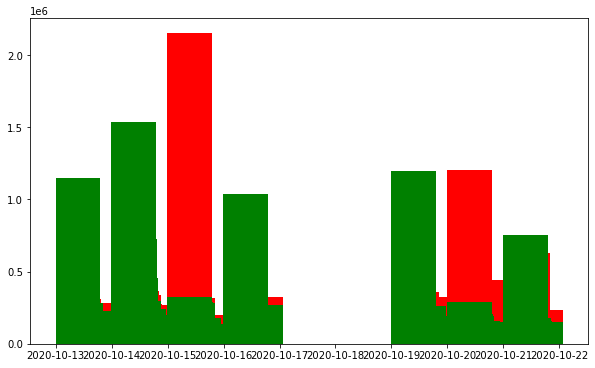

In [36]:
tsla.plot_df()

In [37]:
### Example: 
# macd trading

# let's try TSLA stock again but using macd strategy

In [38]:
tsla = stock('TSLA')
tsla.get_df()
tsla.macd()

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Volume,close_before,relative_price,Color,macd,signal,macd_above
0,2020-10-21 15:59:00-04:00,422.899994,422.999908,422.010010,422.500000,231636,422.885010,-0.385010,red,-0.497865,-0.622021,green
1,2020-10-21 15:58:00-04:00,422.380005,423.000000,422.109985,422.885010,150732,422.309998,0.575012,green,-0.514995,-0.653061,green
2,2020-10-21 15:57:00-04:00,422.894592,422.989990,422.269989,422.309998,133350,422.850006,-0.540009,red,-0.568568,-0.687577,green
3,2020-10-21 15:56:00-04:00,423.130005,423.170013,422.500000,422.850006,122687,423.165009,-0.315002,red,-0.570131,-0.717329,green
4,2020-10-21 15:55:00-04:00,422.943604,423.290009,422.850006,423.165009,108695,422.920013,0.244995,green,-0.618815,-0.754129,green
...,...,...,...,...,...,...,...,...,...,...,...,...
2718,2020-10-13 09:34:00-04:00,442.489990,442.739990,441.010010,442.019989,164946,442.270111,-0.250122,red,0.048668,0.023799,green
2719,2020-10-13 09:33:00-04:00,442.010010,443.000000,441.500000,442.270111,148173,441.850006,0.420105,green,0.048870,0.017581,green
2720,2020-10-13 09:32:00-04:00,442.268707,442.281586,441.454987,441.850006,117819,442.279999,-0.429993,red,0.022950,0.009759,green
2721,2020-10-13 09:31:00-04:00,441.750000,442.980011,441.299988,442.279999,198591,441.875000,0.404999,green,0.032308,0.006462,green


In [40]:
tsla.is_this_a_winner_macd(colors = ['green','green','green'])

True

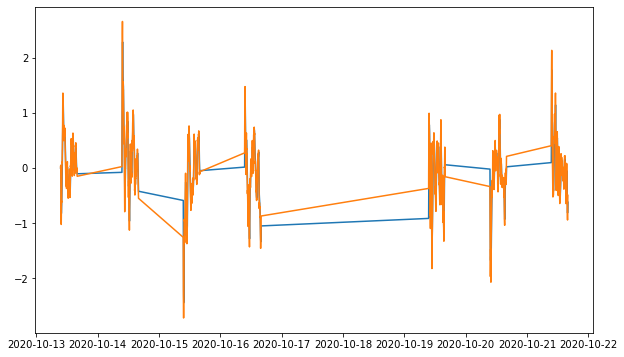

In [42]:
# let's plot the result for macd

df = tsla.macd()
plt.plot(df['Datetime'],df['signal'])
plt.plot(df['Datetime'],df['macd']);


>Voila, the code works fine

### Hunting for winners

- Now let's look at out list of stocks and find ones that meet our condition

Vonage Holdings Corp. - Common Stock is not a winner
Cadence Design Systems, Inc. - Common Stock is not a winner
Urban One, Inc.  - Class A Common Stock is not a winner
Broadcom Inc. - Common Stock is not a winner
Adobe Inc. - Common Stock is not a winner
Alexion Pharmaceuticals, Inc. - Common Stock is not a winner
Limelight Networks, Inc. - Common Stock is not a winner
Maxim Integrated Products, Inc. - Common Stock is not a winner
Ares Capital Corporation - Closed End Fund is not a winner
Costco Wholesale Corporation - Common Stock is not a winner
Genius Brands International, Inc. - Common Stock is not a winner
Foresight Autonomous Holdings Ltd. - American Depositary Shares is not a winner
Curis, Inc. - Common Stock is not a winner
NortonLifeLock Inc. - Common Stock is not a winner
Gevo, Inc. - Common Stock is not a winner
Digital Ally, Inc. - Common Stock is not a winner
Qurate Retail, Inc. - Series A Common Stock is not a winner
Marriott International - Class A Common Stock is not a

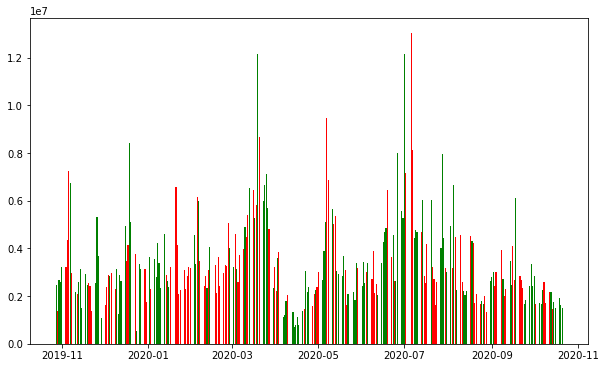

Invesco QQQ Trust, Series 1 is not a winner
Trip.com Group Limited - American Depositary Shares is not a winner
Peloton Interactive, Inc. - Common Stock is not a winner
Amarin Corporation plc - American Depositary Shares, each representing one Ordinary Share is not a winner
SmileDirectClub, Inc. - Common Stock is not a winner
Exelon Corporation - Common Stock is not a winner
Extended Stay America, Inc. - Paired Shares is not a winner
PayPal Holdings, Inc. - Common Stock is not a winner
Horizon Therapeutics Public Limited Company - Ordinary Shares is not a winner
DocuSign, Inc. - Common Stock is not a winner
Sunworks, Inc. - Common Stock is not a winner
Phunware, Inc. - Common Stock is not a winner
Allscripts Healthcare Solutions, Inc. - common stock is not a winner
Monster Beverage Corporation - Common Stock is not a winner
Sunrun Inc. - Common Stock is not a winner
ADiTx Therapeutics, Inc. - Common Stock is not a winner
Ross Stores, Inc. - Common Stock is not a winner
SLM Corporation 

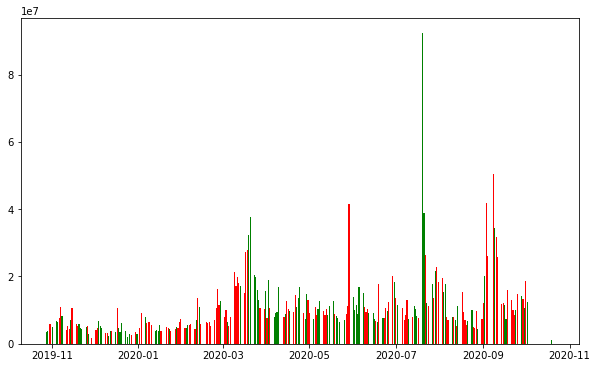

Amazon.com, Inc. - Common Stock is not a winner
Fifth Third Bancorp - Common Stock is not a winner
iShares MSCI ACWI ex US Index Fund is not a winner
Workhorse Group, Inc. - Common Stock is not a winner
Facebook, Inc. - Class A Common Stock is not a winner
Stitch Fix, Inc. - Class A Common Stock is not a winner
Liberty TripAdvisor Holdings, Inc. - Series A Common Stock is not a winner
Xcel Energy Inc. - Common Stock is not a winner
Red Rock Resorts, Inc. - Class A Common Stock is not a winner
T-Mobile US, Inc. - Common Stock is not a winner
Tesla, Inc.  - Common Stock is not a winner
NVIDIA Corporation - Common Stock is not a winner
Western Digital Corporation - Common Stock is not a winner
Creative Realities, Inc. - Common Stock is not a winner
StoneCo Ltd. - Class A Common Share is not a winner
CymaBay Therapeutics Inc. - Common Stock is not a winner
TripAdvisor, Inc. - Common Stock is not a winner
Altimmune, Inc. - Common Stock is not a winner
Marvell Technology Group Ltd. - Common 

In [6]:
winners = []  # a list that we will append with stocks that meet out conditions

for ticker, name in series_tickers.iteritems():
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.macd()
        if my_stock.is_this_a_winner_macd(colors = ['green','green','red']):
            print(name,'is a winner')
            my_stock.plot_df()
            winners.append(ticker)
        else:
            print(name,'is not a winner')
    except:
        continue


- Finally let's look at the list of our winners

In [57]:
winners

['MTCH', 'NBL']

In [58]:
# very short list , we need to adjust the pattern so we got more stocks